# TensorFlow model for sinewave value prediction
Pagal Shawn Hymel:

*Intro to TinyML Part 1: Training a Neural Network for Arduino in TensorFlow*

https://youtu.be/BzzqYNYOcWc



Generate a TensorFlow model that predicts values in a sinewave. Based on the code by Pete Warden at https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb

In [1]:
%tensorflow_version 2.1

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers

In [3]:
# Print versions
!python -V
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

Python 3.8.10
Numpy 1.21.6
TensorFlow 2.11.0
Keras 2.11.0


## Duomenų generavimas
Generuojami duomenys modelio apmokymui

In [4]:
# Settings
# Duomenų parametrai:
nsamples = 3000     # Number of samples to use as a dataset
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set

# Bus naudojama išsaugant modelį
tflite_model_name = 'sine_model'  # Will be given .tflite suffix
c_model_name = 'sine_model'       # Will be given .h suffix

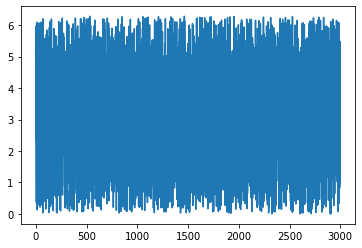

In [5]:
# Generate some random samples
# Atsiktine seka sugeneruoti duomenys nuo 0 iki 2*pi
np.random.seed(42)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values)

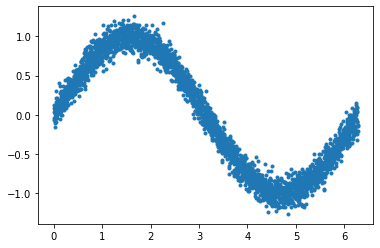

In [6]:
# Create a noisy sinewave with these values
# x duomenų masyvas naudojamas apskaičiuoti atitinkamą sin reikšmę.
# reikšmių išsibarstymui pridedamas Gausian triukšmas 
y_values = np.sin(x_values) + (0.1 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')

## Duomenų rinkinių sudarymas
Padaliname duomenų rinkinį į apmokymo, validavimo ir testavimo

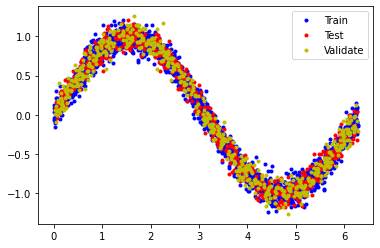

In [7]:
# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

# Modelio sudarymas
Bus naudojamas neuroninis tinklas su dviem paslėptais sluoksniai po 16 neuronų. Tarpusavyje pilnai sujungti - *Dense* modelis.

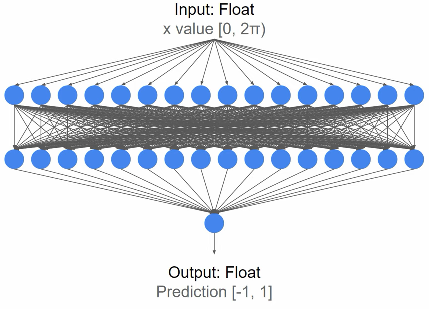

In [8]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

In [9]:
# View model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

## Modelio apmokymas

In [11]:
# Train model
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500
18/18 [==============================] - 1s 15ms/step - loss: 0.5432 - mae: 0.5432 - val_loss: 0.5053 - val_mae: 0.5053
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 0.5087 - mae: 0.5087 - val_loss: 0.4900 - val_mae: 0.4900
Epoch 3/500
18/18 [==============================] - 0s 7ms/step - loss: 0.4846 - mae: 0.4846 - val_loss: 0.4604 - val_mae: 0.4604
Epoch 4/500
18/18 [==============================] - 0s 9ms/step - loss: 0.4607 - mae: 0.4607 - val_loss: 0.4358 - val_mae: 0.4358
Epoch 5/500
18/18 [==============================] - 0s 7ms/step - loss: 0.4368 - mae: 0.4368 - val_loss: 0.4140 - val_mae: 0.4140
Epoch 6/500
18/18 [==============================] - 0s 6ms/step - loss: 0.4155 - mae: 0.4155 - val_loss: 0.3944 - val_mae: 0.3944
Epoch 7/500
18/18 [==============================] - 0s 8ms/step - loss: 0.3947 - mae: 0.3947 - val_loss: 0.3770 - val_mae: 0.3770
Epoch 8/500
18/18 [==============================] - 0s 7ms/step - loss: 0.3759 - 

Braižome apmokymo proceso *history* - apmokymo ir validavimo *loss* reikšmių kitimą.

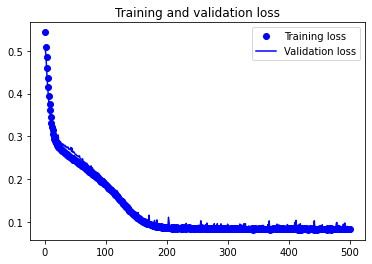

In [12]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Reikšmių spėjimas.
Naudodami *test* rinkinį atliekame reikšmių spėjimą ir braižome grafiką, kad įsitikintume modelio tinkamumu.

19/19 [==============================] - 0s 2ms/step


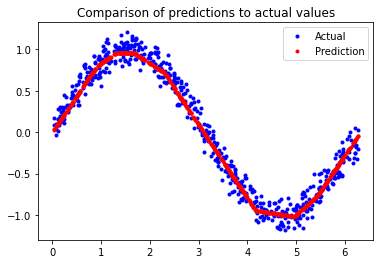

In [13]:
# Make prediction using test data set
predictions = model.predict(x_test)

# Plot predictions against actual values
plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

In [14]:
# Test a few numbers
model.predict(np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]))

1/1 [==============================] - 0s 22ms/step


array([[-0.00100124],
       [ 0.8347112 ],
       [ 0.8315445 ],
       [ 0.09112316],
       [-0.7957907 ],
       [-1.0008689 ],
       [-0.2777617 ]], dtype=float32)

In [15]:
# Save Keras model
model.save(c_model_name + '.h5')

## Modelio konvertavimas į TenzorFlow Lite


In [16]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]  # OPTIMIZE_FOR_SIZE Deprecated. Does the same as DEFAULT.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

3168

Modelis išsaugotas faile *sine_model.tflite* (direktorija *content*).

Atsiųsti į kompiuterį - deš. pelės klavišas -> download

Modelio peržiūrai galima naudoti https://netron.app/ (GitHub: https://github.com/lutzroeder/netron)


## Konvertavimas į C
Linux aplinkoje galima naudoti xxd, tačiau tai netinka Win. Tam paruošiam *hex_to_c_array* f-ja


In [17]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

Išsaugomas *failas.h* kurį galima įtraukti į MV projektą.

In [18]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))